In [1]:
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from math import ceil

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from esda.adbscan import ADBSCAN

from scipy.cluster.hierarchy import dendrogram

import spopt
from spopt.region import MaxPHeuristic as MaxP
import matplotlib.pyplot as plt

import libpysal
import warnings

/Users/xuerongrong/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
lsoa = gpd.read_file('data/lsoa_westminster.gpkg')

<AxesSubplot:>

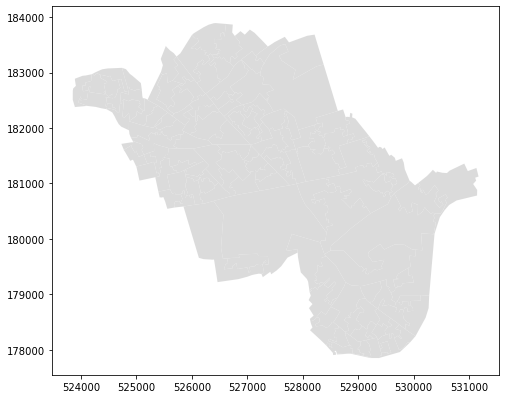

In [3]:
lsoa.plot(figsize=(8,8), color='lightgrey', alpha=0.8)

In [4]:
lsoa.head(3)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E01004646,Westminster 002A,E02000961,Westminster 002,E09000033,Westminster,E12000007,London,1653,1653,0,77.0,616,2.7,"MULTIPOLYGON (((526614.987 183877.891, 526587...."
1,E01004647,Westminster 001A,E02000960,Westminster 001,E09000033,Westminster,E12000007,London,1480,1480,0,75.9,685,2.2,"MULTIPOLYGON (((527129.958 183718.538, 527260...."
2,E01004648,Westminster 002B,E02000961,Westminster 002,E09000033,Westminster,E12000007,London,2398,2398,0,112.1,1122,2.1,"MULTIPOLYGON (((525997.350 183674.612, 526051...."


In [5]:
lsoa = lsoa[['LSOA11CD','geometry']]

In [6]:
off = pd.read_csv('data/off_gas_2019.csv', low_memory=False)

In [7]:
off

,code,name,domestic_properties,gas_meters,on_percentage,mean_consumption,IMD,fuel_poverty
0,E01004646,Westminster 002A,660,552,0.836,23855,14.4,0.14
1,E01004647,Westminster 001A,790,629,0.796,15436,16.3,0.14
2,E01004648,Westminster 002B,1220,984,0.807,15763,10.5,0.13
3,E01004649,Westminster 001B,800,558,0.698,17633,6.4,0.10
4,E01004650,Westminster 002C,1040,770,0.740,17829,6.0,0.10
...,...,...,...,...,...,...,...,...
123,E01033604,Westminster 009J,630,565,0.897,8447,33.5,0.19
124,E01033605,Westminster 009K,870,599,0.689,7493,40.5,0.19
125,E01033606,Westminster 014F,620,476,0.768,8788,14.0,0.17
126,E01033607,Westminster 014G,610,605,0.992,12850,22.2,0.18


In [8]:
lsoaon = pd.merge(lsoa, off, left_on='LSOA11CD', right_on='code')
lsoaon.head(3)

,LSOA11CD,geometry,code,name,domestic_properties,gas_meters,on_percentage,mean_consumption,IMD,fuel_poverty
0,E01004646,"MULTIPOLYGON (((526614.987 183877.891, 526587....",E01004646,Westminster 002A,660,552,0.836,23855,14.4,0.14
1,E01004647,"MULTIPOLYGON (((527129.958 183718.538, 527260....",E01004647,Westminster 001A,790,629,0.796,15436,16.3,0.14
2,E01004648,"MULTIPOLYGON (((525997.350 183674.612, 526051....",E01004648,Westminster 002B,1220,984,0.807,15763,10.5,0.13


In [9]:
#Your also need to divide by 1000000 because .area method give area in square meters.
lsoaon["prop_den"] = lsoaon['domestic_properties'] * 10**6 / lsoaon['geometry'].area 

In [10]:
lsoaon.head(3)

,LSOA11CD,geometry,code,name,domestic_properties,gas_meters,on_percentage,mean_consumption,IMD,fuel_poverty,prop_den
0,E01004646,"MULTIPOLYGON (((526614.987 183877.891, 526587....",E01004646,Westminster 002A,660,552,0.836,23855,14.4,0.14,3101.375219
1,E01004647,"MULTIPOLYGON (((527129.958 183718.538, 527260....",E01004647,Westminster 001A,790,629,0.796,15436,16.3,0.14,4026.548887
2,E01004648,"MULTIPOLYGON (((525997.350 183674.612, 526051....",E01004648,Westminster 002B,1220,984,0.807,15763,10.5,0.13,5682.060664


In [11]:
lsoaon.columns

Index(['LSOA11CD', 'geometry', 'code', 'name', 'domestic_properties',
       'gas_meters', 'on_percentage', 'mean_consumption', 'IMD',
       'fuel_poverty', 'prop_den'],
      dtype='object')

<AxesSubplot:>

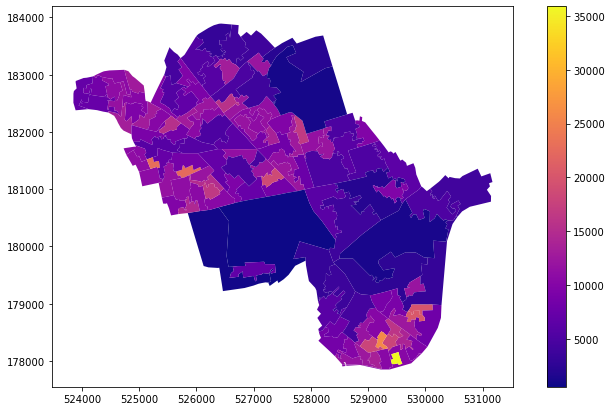

In [12]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
lsoaon.plot(column='prop_den', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

#f.subplots_adjust(top=0.92)
#f.suptitle(f"{measure} House Prices (Raw)", x=0.025, size=24, **tfont);
#plt.savefig('Cluster-House-Prices-Raw.png', dpi=150)

#'domestic properties', 'gas meters', 'on percentage', 'mean consumption', 'IMD','fuel poverty', 'prop_den'

<AxesSubplot:>

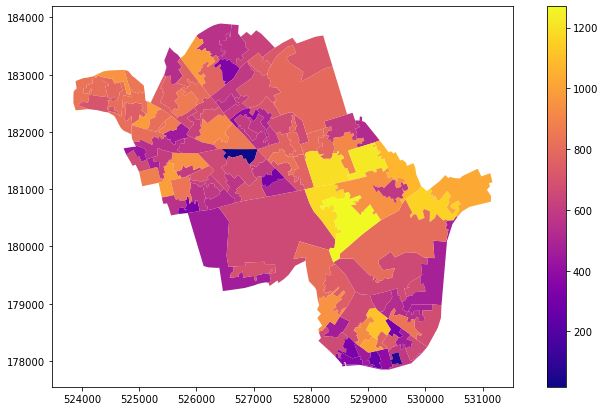

In [13]:
#'domestic properties', 'gas meters', 'on percentage', 'mean consumption', 'IMD','fuel poverty', 'prop_den'
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
lsoaon.plot(column='gas_meters', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

<AxesSubplot:>

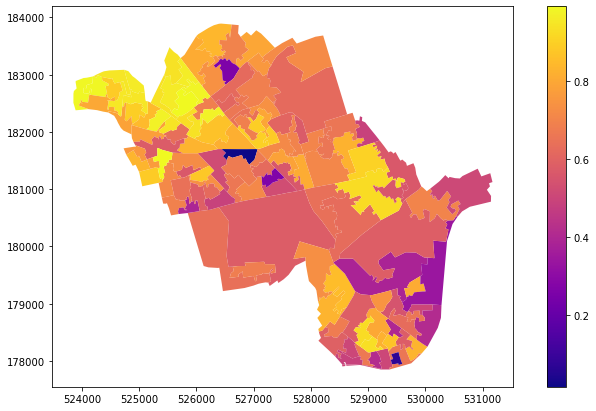

In [14]:
#'domestic properties', 'gas meters', 'on percentage', 'mean consumption', 'IMD','fuel poverty', 'prop_den'
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
lsoaon.plot(column='on_percentage', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

<AxesSubplot:>

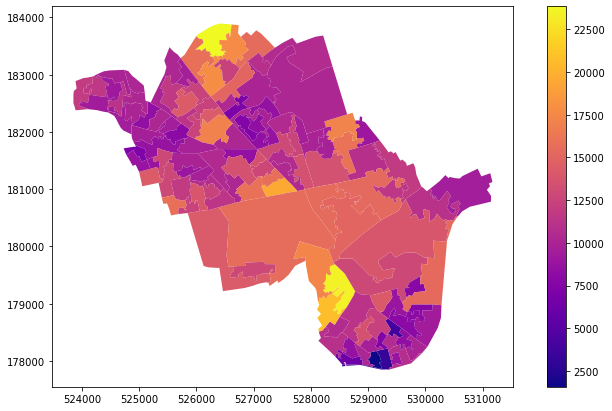

In [15]:
#'domestic properties', 'gas meters', 'on percentage', 'mean consumption', 'IMD','fuel poverty', 'prop_den'
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
lsoaon.plot(column='mean_consumption', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

<AxesSubplot:>

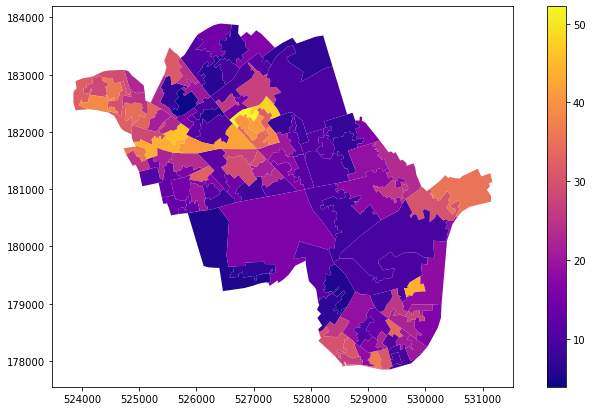

In [16]:
#'domestic properties', 'gas meters', 'on percentage', 'mean consumption', 'IMD','fuel poverty', 'prop_den'
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
lsoaon.plot(column='IMD', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

<AxesSubplot:>

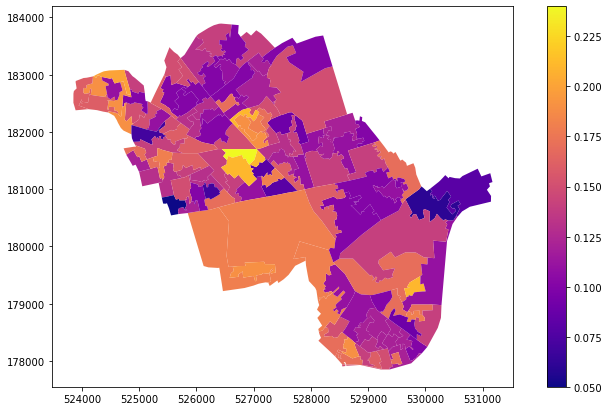

In [17]:
#'domestic properties', 'gas meters', 'on percentage', 'mean consumption', 'IMD','fuel poverty', 'prop_den'
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
lsoaon.plot(column='fuel_poverty', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

In [18]:
#from sklearn.preprocessing import RobustScaler, MinMaxScaler
#rs = RobustScaler(quantile_range=(10.0, 90.0))

In [19]:
#'LSOA11CD', 'geometry', 'code', 'name', 'domestic properties', 
#'gas meters', 'on percentage', 'mean consumption', 'IMD', 
#'fuel poverty', 'prop_den'

raw = lsoaon[['code','on_percentage', 'mean_consumption', 'IMD', 'fuel_poverty', 'prop_den']].set_index('code').copy()
raw.head()

,on_percentage,mean_consumption,IMD,fuel_poverty,prop_den
code,,,,,
E01004646,0.836,23855,14.4,0.14,3101.375219
E01004647,0.796,15436,16.3,0.14,4026.548887
E01004648,0.807,15763,10.5,0.13,5682.060664
E01004649,0.698,17633,6.4,0.10,4129.600371
E01004650,0.740,17829,6.0,0.10,5890.695684


<AxesSubplot:ylabel='Frequency'>

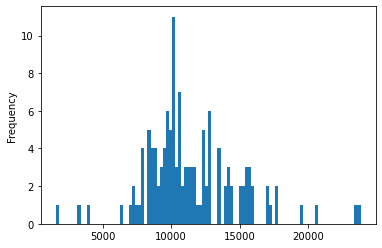

In [20]:
raw.mean_consumption.plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

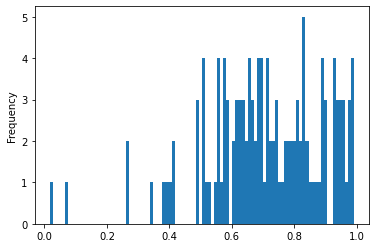

In [21]:
raw.on_percentage.plot.hist(bins=100)

In [22]:
#normed = raw.copy()
#for c in raw.columns.values:
#    normed[c] = rs.fit_transform(raw[c].values.reshape(-1,1))
#    print("The range of {} is [{}, {}]".format(c, normed[c].min(), normed[c].max()))
#normed.head()

In [23]:
# import module
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#model=scaler.fit(raw)
#normed=model.transform(raw)


# import module
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
model = scaler.fit(raw)
normed = model.transform(raw)

In [24]:
normed = pd.DataFrame(normed, 
             columns=['on_percentage', 
                      'mean_consumption',
                      'IMD',
                      'fuel_poverty',
                      'prop_den'])

In [25]:
for c in normed.columns.values:
    print("The range of {} is [{}, {}]".format(c, normed[c].min(), normed[c].max()))

The range of on_percentage is [-3.698558529076884, 1.5082695730877778]
The range of mean_consumption is [-2.879682765058366, 3.6237197344287804]
The range of IMD is [-1.4836259908536849, 2.877108689118656]
The range of fuel_poverty is [-2.4889134708717227, 2.9155843515925888]
The range of prop_den is [-1.7964011764461518, 5.042768268333171]


<AxesSubplot:xlabel='on_percentage', ylabel='mean_consumption'>

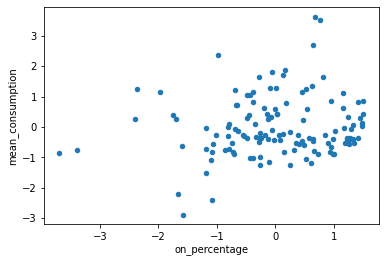

In [26]:
normed.plot.scatter(x= "on_percentage", y="mean_consumption")

In [27]:
def mapping_clusters(labels_cluster):
    lsoaon['cluster_nm'] = labels_cluster
    lsoaon.plot(column='cluster_nm', categorical=True, legend=True, figsize=(12,8), cmap='Pastel2');

In [28]:
def radar_plot_cluster_centroids(df_cluster_centroid):
    # parameters
    # df_cluster_centroid: a dataframe with rows representing a cluster centroid and columns representing variables
    
    # add an additional element to both categories and restaurants that’s identical to the first item
    # manually 'close' the line
    categories = df_cluster_centroid.columns.values.tolist()
    categories = [*categories, categories[0]]
    
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
    
    plt.figure(figsize=(12, 8))
    plt.subplot(polar=True)
    for index, row in df_cluster_centroid.iterrows():
        centroid = row.tolist()
        centroid = [*centroid, centroid[0]]
        label = "Cluster {}".format(index)
        plt.plot(label_loc, centroid, label=label)
    plt.title('Cluster centroid comparison', size=20, y=1.05)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    plt.legend()
    plt.show()

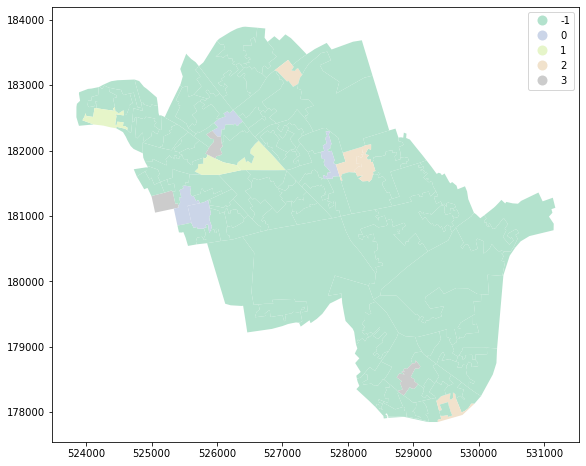

In [37]:
minPts = 3 # we set minPts as normed.shape[1] + 1 
epsilon = 0.6
dbsc = DBSCAN(eps=epsilon, min_samples=minPts)
dbsc.fit(normed)

# We now have our DBSCAN object created, and we can extract the groups it has identified. We do this using the `.labels_` method.
cluster_nm = dbsc.labels_

mapping_clusters(cluster_nm)

In [38]:
from sklearn import metrics
metrics.silhouette_score(normed, dbsc.labels_)

-0.28393862261505043

In [39]:
pd.Series(dbsc.labels_).value_counts()

-1    114
 0      4
 2      4
 3      3
 1      3
dtype: int64

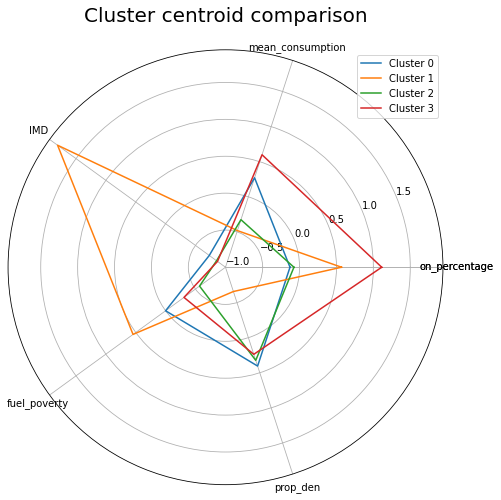

In [40]:
df_dbscan = normed.copy()
df_dbscan['cluster'] = dbsc.labels_
df_dbscan_centroid = df_dbscan.groupby('cluster').mean()
# drop the outlier
df_dbscan_centroid.drop(-1, inplace=True)
# df_dbscan_centroid.reset_index()
radar_plot_cluster_centroids(df_dbscan_centroid)

In [41]:
from sklearn.cluster import KMeans

In [42]:
k_cluster = 4
random_seed = 11
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(normed)

KMeans(n_clusters=4, random_state=11)

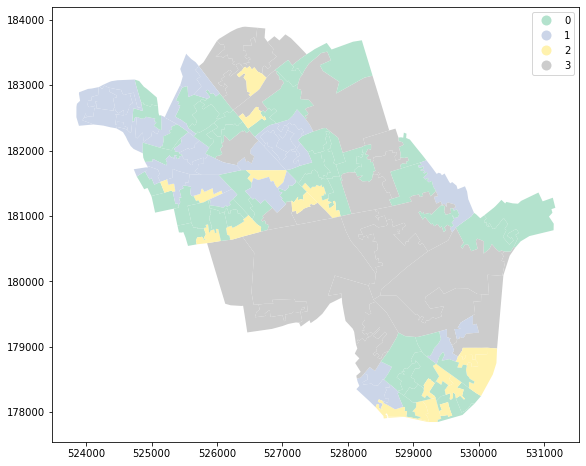

In [43]:
mapping_clusters(kmeans_method.labels_);

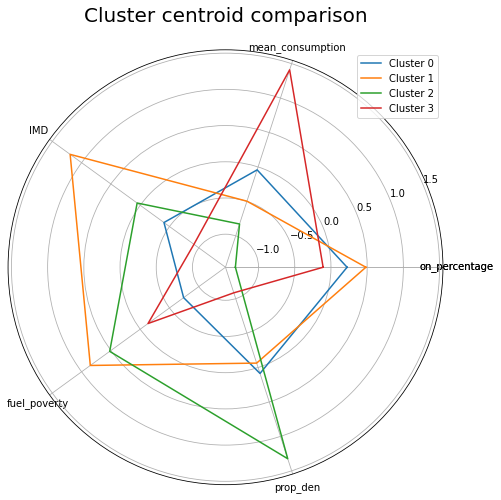

In [44]:
df_cluster_centroid = pd.DataFrame(kmeans_method.cluster_centers_, columns=normed.columns)
radar_plot_cluster_centroids(df_cluster_centroid)

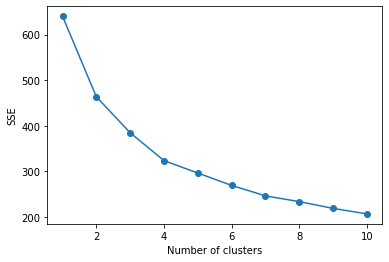

In [45]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(normed)
    # inertia is a concept from physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

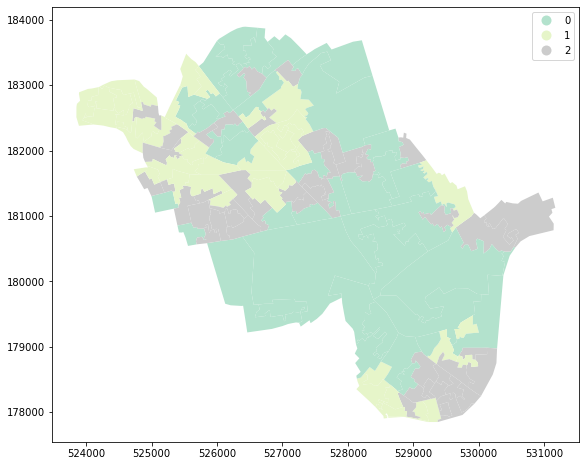

In [46]:
k_cluster = 3
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(normed)

# plotting
mapping_clusters(kmeans_method.labels_);

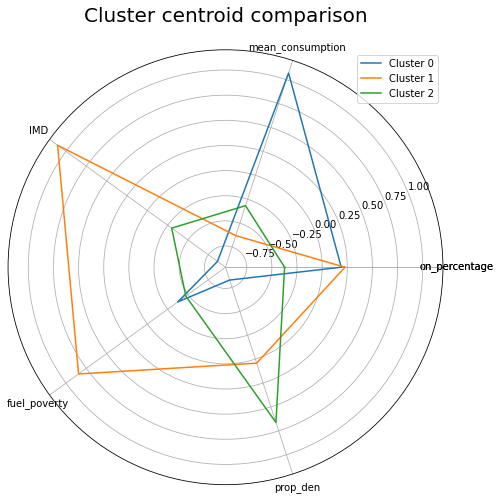

In [47]:
df_cluster_centroid = pd.DataFrame(kmeans_method.cluster_centers_, columns=normed.columns)
radar_plot_cluster_centroids(df_cluster_centroid)

In [48]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, leaf_rotation=90., **kwargs)

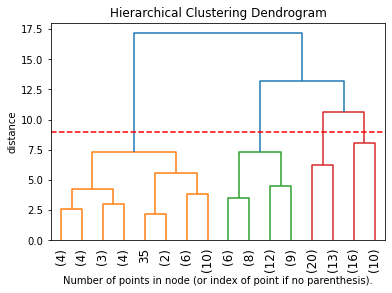

In [56]:
agg_cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(normed)
ax = plt.gca()
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agg_cluster, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel('distance')
plt.hlines(9, ax.get_xlim()[0], ax.get_xlim()[1], linestyle='dashed', color='r')
#plt.hlines(11.5, ax.get_xlim()[0], ax.get_xlim()[1], linestyle='dashed', color='r')
plt.show()

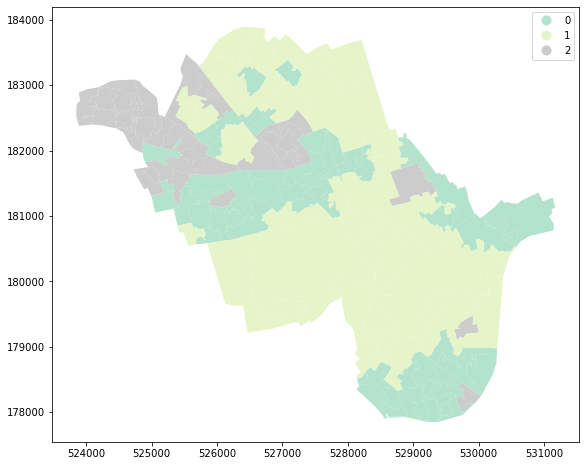

In [57]:
agg_cluster = AgglomerativeClustering(distance_threshold=None, n_clusters=3).fit(normed)
mapping_clusters(agg_cluster.labels_)

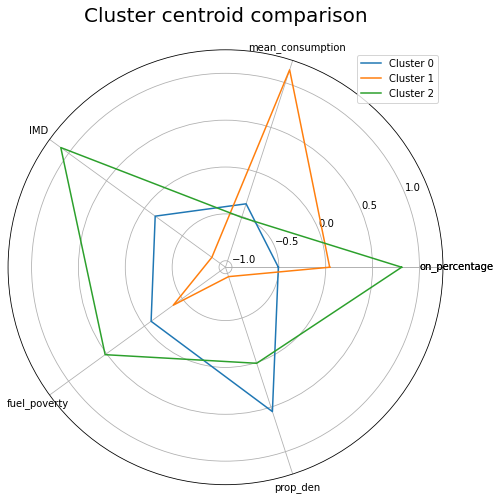

In [58]:
agg = normed.copy()
agg['cluster'] = agg_cluster.labels_
agg_centroid = agg.groupby('cluster').mean()

# df_dbscan_centroid.reset_index()
radar_plot_cluster_centroids(agg_centroid)

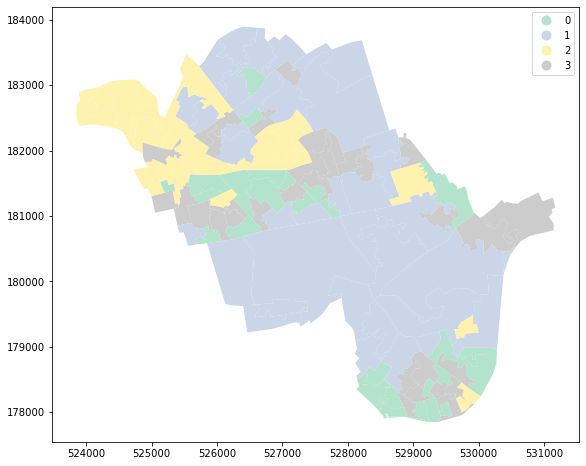

In [59]:
agg_cluster = AgglomerativeClustering(distance_threshold=None, n_clusters=4).fit(normed)
mapping_clusters(agg_cluster.labels_)

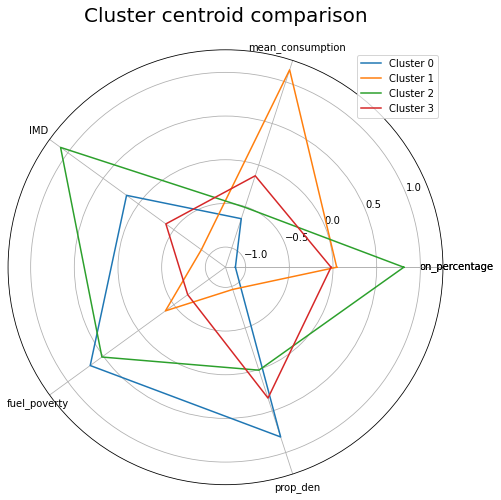

In [60]:
agg = normed.copy()
agg['cluster'] = agg_cluster.labels_
agg_centroid = agg.groupby('cluster').mean()

# df_dbscan_centroid.reset_index()
radar_plot_cluster_centroids(agg_centroid)